In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sodapy import Socrata
import police_data as popo

### API 

In [4]:
client = Socrata("www.dallasopendata.com", app_token=popo.creds['app_token'])

In [46]:
resist_2019_call = client.get('46zb-7qgj', limit=4000)
resist_2018_call = client.get('33un-ry4j', limit=4000)
resist_2017_call = client.get('tsu5-ca6k', limit=4000)
resist_2016_call = client.get('99fn-pvaf', limit=4000)
resist_2015_call = client.get('594v-2cnd', limit=4000)
resist_2014_call = client.get('xiv3-e8g7', limit=4000)
resist_2013_call = client.get('6gnu-avpf', limit=5000)

In [178]:
df_2019 = pd.DataFrame(resist_2019_call)
df_2018 = pd.DataFrame(resist_2018_call)
df_2017 = pd.DataFrame(resist_2017_call)
df_2016 = pd.DataFrame(resist_2016_call)
df_2015 = pd.DataFrame(resist_2015_call)
df_2014 = pd.DataFrame(resist_2014_call)
df_2013 = pd.DataFrame(resist_2013_call)

In [179]:
df_2017.columns

Index(['objectid_1', 'filenum', 'uofnum', 'address', 'occurred_d',
       'occurred_t', 'current_ba', 'offsex', 'offrace', 'hire_dt',
       'off_injure', 'offcondtyp', 'off_hospit', 'service_ty', 'forcetype',
       'uof_reason', 'cycles_num', 'forceeffec', 'street_n', 'street',
       'street_g', 'street_t', 'citnum', 'citrace', 'citsex', 'cit_injure',
       'citcondtyp', 'cit_arrest', 'cit_infl_a', 'citcharget', 'ra', 'beat',
       'sector', 'division', 'dist_name', 'x', 'y', 'geolocation',
       ':@computed_region_sjyw_rtbm', ':@computed_region_2f7u_b5gs',
       'taag_name'],
      dtype='object')

### Table for database

In [180]:
# seeing if all dfs have same columns we're looking for

dfs = [df_2019,df_2018,df_2017,df_2016,df_2015,df_2014,df_2013]
years = ['df_2019','df_2018','df_2017','df_2016','df_2015','df_2014','df_2013']
headers = ['objectid','filenum', 'uofnum', 'forceeffec', 'forcetype']
for n, x in enumerate(dfs):
    for y in headers:
        if y in x.columns:
            pass
        else:
            print(f"{y} not in {years[n]}")

objectid not in df_2018
objectid not in df_2017
objectid not in df_2015
forceeffec not in df_2015


In [181]:
df_2015.rename(columns={'forceeffective':'forceeffec'}, inplace=True)
df_2017.rename(columns={'objectid_1':'objectid'}, inplace=True)
df_2015.rename(columns={'id':'objectid'}, inplace=True)
#2018 does not have an id column, but it is just a numerical increment
df_2018['objectid'] = [str(x+1) for x in range(len(df_2018))]

In [182]:
# seeing if length of comma-separated values in records are the same across fields
for n, df in enumerate(dfs):
    for x, y, z in zip(df.uofnum, df.forceeffec, df.forcetype):
        if len(str(x).split(",")) == len(str(y).split(",")) and len(str(y).split(",")) == len(str(z).split(",")):
            pass
        else:
            print(f"{years[n]}: {x},{y},{z}")

df_2013: 0,Yes, No,Other, Verbal Command
df_2013: 0,Yes, Yes,Weapon display at Person, BD - Pushed
df_2013: 0,Yes, Yes, Yes,Hand/Arm Strike, Arm Bar, Team Take Down
df_2013: 0,No, Yes, Yes,Verbal Command, Hand/Arm Strike, Handcuffing
df_2013: 0,No, Yes,Verbal Command, Handcuffing
df_2013: 0,No, No, No,Attempted Take Down, Feet/Legs, Hands/Arms
df_2013: 0,Yes, Yes,Weapon display at Person, Arm Bar
df_2013: 0,Yes, Yes,Weapon display at Person, Verbal Command
df_2013: 0,Yes, Yes,Verbal Command, Weapon display at Person
df_2013: 0,Yes, Yes,Arm Bar, Hand/Arm Strike
df_2013: 0,Yes, Yes,Arm Bar, Handcuffing
df_2013: 0,No, Yes,Verbal Command, Weapon display at Person
df_2013: 0,No, Yes,Arm Bar, OC Spray
df_2013: 0,Yes, Yes,Team Take Down, Stacked Weight
df_2013: 0,No, Yes, Yes,BD - Grabbed, Take Down - Head, Feet/Leg/Knee Strike
df_2013: 0,Yes, Yes, Yes,Arm Take Down, Balance Displacement, Feet/Legs
df_2013: 0,No, No, Yes,Verbal Command, Verbal Command, Arm Bar
df_2013: 0,No, Yes,Verbal Comman

<br>So we're good across all dataframes with the exception of these records from 2013 where the UOFnum equals 0. Perhaps these should be dropped since they are a relatively insignificant number?

In [183]:
df_2013 = df_2013[df_2013.uofnum != "0"]
df_2013.reset_index(drop=True, inplace=True)

In [184]:
# 2014 has one value at the very end of uofnum that is nan; removing it
df_2014.drop(index=3395, inplace=True)

In [191]:
def expand_record(record, lst_appnd):
    global commas
    global n
    commas = False
    if "," in record:
        x = record.split(",")
        for y in x:
            lst_appnd.append(y.lstrip())
        commas = True
        n = len(x)
    else:
        lst_appnd.append(record.lstrip())

In [199]:
dfs = [df_2019,df_2018,df_2017,df_2016,df_2015,df_2014,df_2013] #dfs have been changed
objectid = []
filenum = []
uofnum = []
forceeffec = []
forcetype = []
for df in dfs:
    for objid, fno, uof, foreffc, fortyp in zip(df.objectid, df.filenum, df.uofnum, 
                                               df.forceeffec, df.forcetype):
        expand_record(uof, uofnum)
        if commas == True:
            for nn in range(n):
                objectid.append(objid)
                filenum.append(fno)
            commas = False
        else:
            filenum.append(fno)
            objectid.append(objid)
        expand_record(foreffc, forceeffec)
        expand_record(fortyp, forcetype)

In [200]:
data = {'objectid':objectid, 'filenum':filenum, 'uofnum':uofnum, 
        'forceeffec':forceeffec, 'forcetype':forcetype}
table1 = pd.DataFrame(data)
table1

,objectid,filenum,uofnum,forceeffec,forcetype
0,2817,UF2019-1702,62295,Yes,BD - Tripped
1,2817,UF2019-1702,63542,Yes,BD - Grabbed
2,2234,UF2019-1344,61093,Yes,Held Suspect Down
3,2755,UF2019-1665,62820,Yes,K-9 Deployment
4,2110,UF2019-1314,60990,Yes,Joint Locks
...,...,...,...,...,...
43043,4015,UF2013-02851,5354,No,Weapon display at Person
43044,4015,UF2013-02851,5357,Yes,Joint Locks
43045,4015,UF2013-02851,5359,Yes,Handcuffing
43046,4015,UF2013-02851,5361,No,Verbal Command


In [201]:
table1.forcetype.value_counts()

Verbal Command              8922
Held Suspect Down           4846
Weapon display at Person    4779
BD - Grabbed                2606
Joint Locks                 2499
Take Down - Arm             1960
Hand Controlled Escort      1702
Take Down - Body            1539
Taser                       1369
Handcuffing Take Down       1021
BD - Pushed                 1001
Taser Display at Person      924
Hand/Arm/Elbow Strike        875
Foot Pursuit                 814
Pressure Points              795
Balance Displacement         724
Handcuffing                  701
Feet/Leg/Knee Strike         609
OC Spray                     567
Hand Control Technique       523
Stacked Weight               459
Arm Bar                      439
Hands/Arms                   389
BD - Tripped                 373
Take Down - Group            331
Take Down - Head             299
Leg Restraint System         269
Other                        238
Feet/Legs Strike             237
Hand/Arm Strike              209
Team Take 

### Misc. exploration

In [4]:
df_2019.CitRace.value_counts(normalize=True)

Black           0.539917
Hispanic        0.226084
White           0.220234
Asian           0.006194
Other           0.003785
American Ind    0.002409
Unknown         0.001376
Name: CitRace, dtype: float64

In [5]:
df_2019.CIT_INJURE.value_counts()

False    2259
True      685
Name: CIT_INJURE, dtype: int64

In [6]:
freq = []
for x in df_2019.forcetype:
    if "," in x:
        y = x.split(",")
        for z in y:
            freq.append(z.lstrip())
    else:
        freq.append(x)

In [7]:
freq_dict = (pd.Series(freq).value_counts()).to_dict()

In [8]:
freq_dict

{'Verbal Command': 1235,
 'Held Suspect Down': 848,
 'Foot Pursuit': 693,
 'Weapon display at Person': 548,
 'BD - Grabbed': 481,
 'Take Down - Body': 303,
 'Joint Locks': 297,
 'Hand Controlled Escort': 268,
 'Take Down - Arm': 262,
 'Taser': 195,
 'BD - Pushed': 168,
 'Hand/Arm/Elbow Strike': 161,
 'Taser Display at Person': 159,
 'Handcuffing Take Down': 145,
 'Feet/Leg/Knee Strike': 105,
 'Pressure Points': 79,
 'BD - Tripped': 77,
 'Take Down - Head': 53,
 'Take Down - Group': 49,
 'OC Spray': 40,
 'Leg Restraint System': 33,
 'K-9 Deployment': 20,
 '40mm Less Lethal': 11,
 'Other Impact Weapon': 5,
 'Combat Stance': 5,
 'LVNR': 4,
 'Baton Strike/Open Mode': 3,
 'Baton Display': 3,
 'Pepperball Impact': 2,
 'Vehicle Pursuit': 2,
 'Pepperball Saturation': 1,
 'Head Butt': 1}

In [23]:
df_2019.UOF_REASON.value_counts(normalize=True)

Arrest                      0.496765
Active Aggression           0.129384
Detention/Frisk             0.123936
Danger to self or others    0.090909
Weapon Display              0.071161
Other                       0.060947
Assault to Other Person     0.017024
Crowd Disbursement          0.005448
Barricaded Person           0.003064
Property Destruction        0.001362
Name: UOF_REASON, dtype: float64

In [22]:
df_2019['Council District'].value_counts(normalize=True)

D2     0.131741
D7     0.121160
D14    0.113993
D6     0.078498
D1     0.074403
D10    0.071672
D4     0.065188
D9     0.065188
D8     0.057679
D11    0.056997
D5     0.049147
D12    0.041297
D13    0.040956
D3     0.032082
Name: Council District, dtype: float64

In [24]:
df_2019.OffRace.value_counts()

White           1703
Hispanic         737
Black            351
Asian            107
Other             27
American Ind      19
Name: OffRace, dtype: int64

In [43]:
df_2019.HIRE_DT = pd_2019.to_datetime(df.HIRE_DT)

In [49]:
df_2019[['HIRE_DT', 'OffRace']]

,HIRE_DT,OffRace
0,2017-03-08,White
1,2016-08-24,White
2,2008-04-02,White
3,2009-06-10,Hispanic
4,2012-09-26,Hispanic
...,...,...
2939,1990-11-26,White
2940,1991-07-29,Black
2941,2003-08-18,White
2942,2004-06-04,White


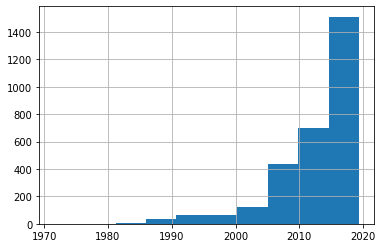

In [50]:
df_2019.HIRE_DT.hist();